<a href="https://colab.research.google.com/github/heber-augusto/sus-kpis-analysis/blob/main/sia/analise_exploratoria_pacientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação
Este notebook foi desenvolvido como parte do projeto Monitor Rosa, um conjunto de ferramentas, softwares e outros artefatos cujo principal objetivo é melhorar o cenário de diagnósticos de câncer de mama no Brasil, idealmente melhorando diminuindo a proporção de diagnósticos tardios/diagnósticos precoces.

O arquivo utilizado nesta análise exploratória foi gerado a partir [deste notebook](https://github.com/heber-augusto/sus-kpis-analysis/blob/main/sia/indicadores_monitor_rosa_sia_pa.ipynb), que é um parte do [repositório de análises e criação de kpis](https://github.com/heber-augusto/sus-kpis-analysis).

# Dataset de Pacientes (1 linha por paciente)

Colunas:

 - Chave da paciente (cns_encrypted)
 - Custo total do tratamento
 - Estadiamento inicial
 - Estadiamento final
 - Indicação de óbito
 - Localização de moradia

## Premissas consideradas:

 - Tipos de arquivos a serem utilizados: AQ e AR
 - chave do paciente:
  - AQ: coluna AP_CNSPCN
  - AR: coluna AP_CNSPCN  
 - custo total do tratamento: será uma estimativa considerando apenas radioterapia e quimioterapia, calculado somando os valores dos procedimentos (presentes em AR e AQ), para cada chave de paciente. Sendo:
   - custos em AQ: soma de AP_VL_AP;
   - custos em AR: soma de AP_VL_AP.
 - Estadiamento inicial: calculado utilizando o valor do estadiamento (presentes em AQ:AQ_ESTADI e AR:AR_ESTADI) do registro mais antigo de radioterapia ou quimioterapia, de um determinado paciente;
 - Estadiamento final: calculado utilizando o valor do estadiamento (presentes em AQ:AQ_ESTADI e AR:AR_ESTADI) do registro mais recente de radioterapia ou quimioterapia, de um determinado paciente;
 - Localização de moradia: utilizar coluna AP_MUNPCN (presentes em AR e AQ). Talvez criar dois campos, AP_MUNPCN presente no registro mais antigo e AP_MUNPCN presente no registro mais novo;
 - Indicação de óbito: valor máximo do campo AP_OBITO, presente em AQ e AR (0: sem indicação e 1:com indicação de óbito) O valor 1 indicará óbito.

# Instalação de bibliotecas

## Bibliotecas utilizadas na análise exploratória

In [25]:
import pandas as pd
import numpy as np 
import seaborn as sns

In [2]:
pacientes = pd.read_parquet('https://github.com/heber-augusto/sus-kpis-analysis/blob/a596c6f4f121c1ba3ae7b998143525657fa19837/sia/pacientes.parquet.gzip?raw=true')
pacientes.head()

,paciente,data_primeiro_estadiamento,data_ultimo_estadiamento,primeiro_estadiamento,maior_estadiamento,ultimo_estadiamento,custo_total,primeiro_municipio,ultimo_municipio,indicacao_obito
0,898 0000 8725 6,201107,201108,2,2,2,3928.00,355220,355220,0
1,8980500671835 8,200903,200905,2,2,2,239.25,354890,354890,0
2,{{}{{{{{|,201004,201006,3,3,3,239.25,352900,352900,0
3,{}{|}{{|,200910,201105,1,1,1,4283.69,353660,353660,0
4,{}{~~~||{{{~,201102,201104,3,3,3,2400.00,510030,510030,0


In [3]:
pacientes.sort_values(by='data_primeiro_estadiamento')

,paciente,data_primeiro_estadiamento,data_ultimo_estadiamento,primeiro_estadiamento,maior_estadiamento,ultimo_estadiamento,custo_total,primeiro_municipio,ultimo_municipio,indicacao_obito
132357,{{|{{{{}~,200801,200802,1,1,1,159.50,355030,355030,0
119116,{{{|}{,200801,200807,2,4,2,7423.24,350170,350170,0
119117,{{{|},200801,200912,1,1,1,1914.00,350320,350320,0
119118,{{{|}},200801,201601,2,3,2,26833.50,355270,355370,0
119119,{{{|~{{~,200801,201502,2,3,2,24723.00,352930,352930,0
...,...,...,...,...,...,...,...,...,...,...
69340,{{{~}|}|},202202,202202,2,2,2,1400.00,354150,354150,0
41528,{||{~{{,202202,202202,1,1,1,79.75,350800,350800,0
102691,{|{|},202202,202202,2,2,2,1400.00,355030,355030,0
9227,}{{~}~||{{{,202202,202202,2,2,2,5904.00,354780,354780,0


## Transformação das colunas de data/hora

In [4]:
pacientes['data_primeiro_estadiamento_dt'] = pd.to_datetime(
    pacientes['data_primeiro_estadiamento'],
    format='%Y%m')

pacientes['data_ultimo_estadiamento_dt'] = pd.to_datetime(
    pacientes['data_ultimo_estadiamento'],
    format='%Y%m')

## Cria coluna de tempo de tratamento
Premissa considerada: tempo de tratamento é calculado, em meses, a partir da diferença entre data_primeiro_estadiamento e data_ultimo_estadiamento

In [10]:
pacientes['tempo_tratamento'] = ((pacientes['data_ultimo_estadiamento_dt'] - pacientes['data_primeiro_estadiamento_dt'])/np.timedelta64(1, 'M')).round(0).astype(int)
pacientes['tempo_tratamento']

0          1
1          2
2          2
3         19
4          2
          ..
180789    53
180790    60
180791     2
180792     1
180793    11
Name: tempo_tratamento, Length: 180794, dtype: int64

## Métricas de pacientes calculadas por estadiamento inicial (valor do estadiamento no primeiro registro de exame)
 - número de pacientes
 - custo médio;
 - tempo médio de tratamento;
 - número de óbitos.

In [26]:
pacientes\
    .groupby(['primeiro_estadiamento'])\
    .agg(
        numero_pacientes=('paciente', 'count'),        
        media_custo=('custo_total', 'mean'),
        media_tempo=('tempo_tratamento', 'mean'),
        obtios=('indicacao_obito', 'sum'),
        )\
    .reset_index()
   

,primeiro_estadiamento,numero_pacientes,media_custo,media_tempo,obtios
0,,58,6747.090517,8.551724,8
1,0,12695,10298.182219,27.787082,309
2,1,37296,6599.655721,35.860628,395
3,2,57784,9525.719560,36.552592,1474
4,3,52182,14309.220525,32.333889,2914
5,4,20779,16421.280970,22.638144,2344


## Limpeza de dados (remoção de valores inválidos)
Linhas com estadiamentos inicial abaixo de 1 ou vazios foram removidas

In [39]:
pacientes_final = pacientes[(pacientes.primeiro_estadiamento != '')]
pacientes_final =pacientes_final[(pacientes_final.primeiro_estadiamento.astype(int) > 0)]




## Métricas de pacientes calculadas por estadiamento inicial (valor do estadiamento no primeiro registro de exame) - pós limpeza
 - número de pacientes
 - custo médio;
 - tempo médio de tratamento;
 - número de óbitos.

In [43]:
pacientes_final\
    .groupby(['primeiro_estadiamento'])\
    .agg(
        numero_pacientes=('paciente', 'count'),        
        media_custo=('custo_total', 'mean'),
        media_tempo=('tempo_tratamento', 'mean'),
        obitos=('indicacao_obito', 'sum'),
        )\
    .reset_index()

,primeiro_estadiamento,numero_pacientes,media_custo,media_tempo,obitos
0,1,37296,6599.655721,35.860628,395
1,2,57784,9525.719560,36.552592,1474
2,3,52182,14309.220525,32.333889,2914
3,4,20779,16421.280970,22.638144,2344


## Insights:
 - custo médio por 
 paciente aumenta, conforme o estadiamento inicial;
 - A relação óbitos/número pacientes aumenta conforme o estadiamento inicial.
 - O tempo de tratamento de diagnostico precoce (estadiamento 1 e 2) é, aparentemente menor que o de diagnostico tardio (estadiamento 3 e 4).

## % de pacientes (com e sem indicação de óbito) em cada estadiamento inicial
Objetivo aqui é entender quanto o estadiamento inicial impacta na % de óbitos.


In [42]:
percentual = pd.crosstab(
    pacientes_final.primeiro_estadiamento,
    pacientes_final.indicacao_obito,
    aggfunc='count',
    values = pacientes_final.paciente,
    normalize='index'
    )
percentual

indicacao_obito,0,1
primeiro_estadiamento,,
1,0.989409,0.010591
2,0.974491,0.025509
3,0.944157,0.055843
4,0.887194,0.112806


## Insights
 - A % de pacientes com indicação de óbito aumenta conforme o estadiamento do primeiro registro de exame aumenta;
 - Apesar da quantidade de pacientes com diagnóstico em estadiamento 4 ser menor que a quantidade de pacientes com diagnóstico em estadiamento 3, a % de pacientes com indicação de óbito é quase 2x maior (11.3% contra 5.6%).

# Distribuição do custo total x estadiamento do diagnóstico (estadiamento do primeito registro de tratamento)

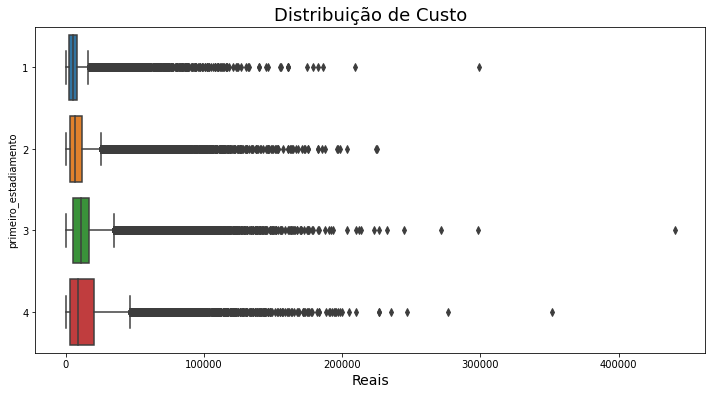

In [49]:
ax = sns.boxplot(
    x='custo_total',
    y='primeiro_estadiamento',    
    data=pacientes_final,
    orient='h',
    order=['1','2','3','4'])

ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Custo', fontsize=18)
_ = ax.set_xlabel('Reais', fontsize=14)

# Distribuição do tempo de tratamento x estadiamento do diagnóstico (estadiamento do primeito registro de tratamento)

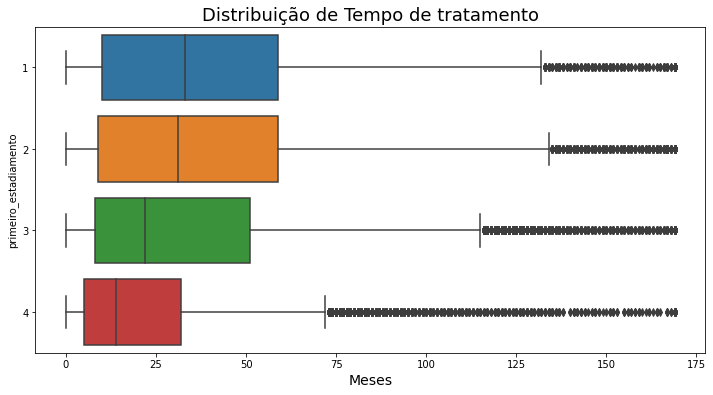

In [51]:
ax = sns.boxplot(
    x='tempo_tratamento',
    y='primeiro_estadiamento',    
    data=pacientes_final,
    orient='h',
    order=['1','2','3','4'])

ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Tempo de tratamento', fontsize=18)
_ = ax.set_xlabel('Meses', fontsize=14)